## 序列模型
使用正弦函数和一些可加性噪声生成序列数据

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

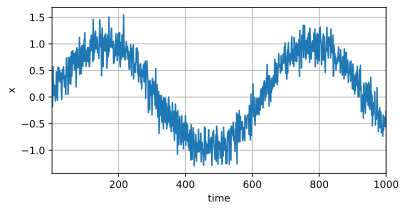

In [10]:
T = 1000
time = torch.arange(1, T + 1, dtype = torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

基于嵌入维度$\tau$，我们[**将数据映射为数据对$y_t = x_t$ 和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]
这比我们提供的数据样本少了$\tau$个，
因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；
另一个方法是用零填充序列。

In [11]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i : T - tau + i]
labels = x[tau:].reshape((-1 , 1))
# features = [【x1, x2, x3, x4】,
#                   【x2, x3, x4, x5】,
#                    ...
#                   【x996, x997, x998, x999】
#             ]
# labels = [【x5】,
#              【x6】,
#              ...
#              【x1000】]

In [28]:
# 仅使用前600个“特征－标签”对进行训练。
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                             batch_size, is_train=True)

In [27]:
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 多层感知机        
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weight)
    return net

# 平方损失
loss = nn.MSELoss()

In [25]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
             trainer.zero_grad()
             y_hat = net(X)
             l = loss(y_hat, y)
             l.backward()
             trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss)}')

In [30]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.06351006624141806
epoch 2, loss: 0.052839135211941446
epoch 3, loss: 0.05174557845059194
epoch 4, loss: 0.05322207157549105
epoch 5, loss: 0.04798883283020634


### 预测下一个时间步

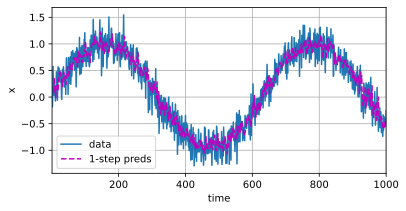

In [32]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3)
)

### 进行多步预测
通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$
称为$k$*步预测*（$k$-step-ahead-prediction）。
由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。
换句话说，我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。

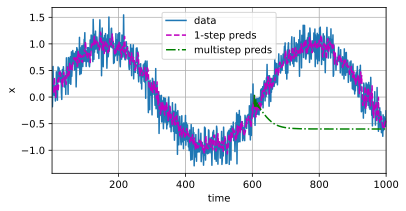

In [33]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

这个算法效果这么差事实是由于错误的累积：
假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。于是，步骤$2$的输入被扰动了$\epsilon_1$，
结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，
其中$c$为某个常数，后面的预测误差依此类推。因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，但超过这一点，精度就会迅速下降。

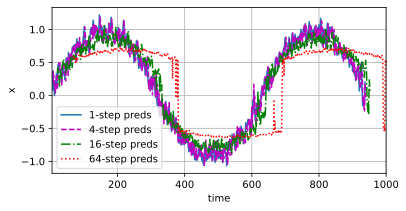

In [34]:
# 变化k对整个序列进行预测
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))